# [1]. Reading Data

Let me copy code from my previous assignment where we are doing preprocessing steps like deduplication,removal of stop words, decontraction of words,lemmatization etc.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My\ Drive

/content/drive/My Drive


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [99]:

#con = sqlite3.connect(r"D:\AppliedAI\AAIC_Course_handouts\11_Amazon Fine Food Reviews\amazon-fine-food-reviews\database.sqlite")
con = sqlite3.connect(r"database.sqlite")
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)
#data = pd.read_csv(""" SELECT * FROM Reviews WHERE Score != 3""",con)

# Change Score with 1 n 2 as -ve and 4 n 5 as +ve

def chng_to_0_or_1 (Score):
    if Score ==4 or Score ==5:
        return 1
    elif Score ==1 or Score ==2:
        return 0
    else:# Thus in case by some mistake any data is their with rating 6 or 7 etc due to some error is removed
        pass
currentScore = data["Score"]
new_Score = currentScore.map(chng_to_0_or_1)
data["Score"] = new_Score
print ("Number of data points available")
print (data.shape)#Gives original number of data points available


#2 Data Cleaning a.) Getting rid of duplicates and b.) if helpnessdenominator < helpfulnessnumerator


data = data.drop_duplicates(subset = ["UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary","Text"], keep='first', inplace=False)
print ("Number of data points after removing duplicates")
print (data.shape)#Gives data points are deduplication

# Reference: Copied from above cell  final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print ("Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator ")
print (data.shape)

#3 Preprocessing begins

#Convert to lower case,convert shortcut words to proper words, remove Special Character

#i) Convert to lower case:
data["Text"] =  (data["Text"].str.lower())
data["Summary"] =  (data["Summary"].str.lower())

#ii) Convert Shortcuts words to proper words
#List of Words are:https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#Reference:https://stackoverflow.com/questions/39602824/pandas-replace-string-with-another-string
data['Text'] = data['Text'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
##############Lets do the same for summary Text##################################
data['Summary'] = data['Summary'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
########################################################################################
# iii) Remove Special Characters except alpahbets and numbers
#The reason i dont want to remove number people might write got five eggs as 5 eggs or vice versa and dont want to lose 
#that information which could be useful
#Ref:https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
data["Text"]=data["Text"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))
data["Summary_copy"]=data["Summary"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))

#The Summary are usually so small if we remove few stopwords the meaning itself would be complely lost or chamge
# So let us see what all stopwords we have
#Ref:::::::::https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['would','could','br','<br>','<','>']
notstopwords = ['not','no','nor']
stopwords.extend(newStopWords)
stopwords = [word for word in stopwords if word not in notstopwords]

#  iv) For now let us just go with flow will use default stopwords as creating our own stop words is very time consuming
#Rather will use n-gram stratergy to get rid of problem of stopwords removal changing the meaning of sentences
#Ref:https://stackoverflow.com/questions/43184364/python-remove-stop-words-from-pandas-dataframe-give-wrong-output
data["New_Text"]= data['Text'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])
data["Summary"]= data['Summary_copy'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])

#Ref:https://stackoverflow.com/questions/37347725/converting-a-panda-df-list-into-a-string/37347837
#we are creating new column New_summary so in case in future we need summary it is intact
data["New_Text"]=data["New_Text"].apply(' '.join)
data["Summary"]=data["Summary"].apply(' '.join)

# v) Now lets do Stemming
#https://stackoverflow.com/questions/48617589/beginner-stemming-in-pandas-produces-letters-not-stems
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
data["New_Text"] = data["New_Text"].apply(english_stemmer.stem)
data["Summary"] = data["Summary"].apply(english_stemmer.stem)
data["New_Text"] = data["New_Text"].astype(str)
data["Summary"] = data["Summary"].astype(str)

#vi) stemming without removing stop words
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
data["Text_with_stop"]=data["Text"].astype(str)
data["Summary"]=data["Summary"].astype(str)
data["Text_with_stop"]=data["Text_with_stop"].str.lower().map(english_stemmer.stem)
data["Summary"]=data["Summary"].str.lower().map(english_stemmer.stem)
data["Text_with_stop"]=data["Text_with_stop"].apply(''.join)
data["Summary"]=data["Summary"].apply(''.join)
data["Text_with_stop"] = data["Text_with_stop"].astype(str)
data["Summary"] = data["Summary"].astype(str)
print(data["Score"].value_counts())
print ("Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced \
dataset we first copy negative dataset 6 times than we sample with same number of times as positive")
# Let include another feature which is the length of the text 
data_neg = data[data["Score"] == 0]
data_pos = data[data["Score"] == 1]
data = pd.concat([data_pos,data_neg])
#https://stackoverflow.com/questions/46429033/how-do-i-count-the-total-number-of-words-in-a-pandas-dataframe-cell-and-add-thos
data["Text_length"]= (data["New_Text"].str.count(' ') + 1)
data["Summary_length"]= (data["Summary"].str.count(' ') + 1)
data["Time_formatted"]= pd.to_datetime(data["Time"])
data.sort_values(by=['Time_formatted'], inplace=True)

Number of data points available
(525814, 10)
Number of data points after removing duplicates
(366392, 10)
Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator 
(366390, 10)
1    308679
0     57711
Name: Score, dtype: int64
Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced dataset we first copy negative dataset 6 times than we sample with same number of times as positive



Let us keep "data" frame intact so incase something gets corrupted we can resuse it. We will create a new dataframe without "Score" column named "newdata"

In [0]:
newdata = data

In [0]:
newdata_50K = newdata.tail(50000)
newdata_50K.sort_values(by=['Time_formatted'], inplace=True)


In [103]:
X_no_stop_50k_reviews = newdata_50K['New_Text'].values
print ((X_no_stop_50k_reviews).shape)

(50000,)


In [0]:
sent= (X_no_stop_50k_reviews.tolist())

# [4] Featurization

## [4.3] TF-IDF

In [105]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=9000)

tfidf_X_no_stop_50k_reviews=tf_idf_vect.fit_transform(X_no_stop_50k_reviews)
print("some sample features(unique 100 words in the corpus)",tf_idf_vect.get_feature_names()[0:100])
print('='*50)
print("the shape of out text TFIDF vectorizer ",tfidf_X_no_stop_50k_reviews.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_X_no_stop_50k_reviews.get_shape()[1])

some sample features(unique 100 words in the corpus) ['10', '10 12', '10 days', '10 minutes', '10 seconds', '10 year', '10 years', '100', '100 calorie', '100 calories', '100 pure', '1000', '10oz', '11', '110', '12', '12 cans', '12 cup', '12 cups', '12 ounce', '12 oz', '12 pack', '12 year', '12 years', '120', '125', '129', '12a', '12oz', '13', '13 cup', '130', '14', '14 cup', '140', '15', '15 liter', '15 minutes', '15 years', '150', '16', '16 ounce', '16 oz', '160', '169', '16oz', '17', '170', '18', '180', '19', '1st', '20', '20 minutes', '20 years', '200', '2011', '2012', '2013', '21', '22', '23', '24', '24 hours', '24 pack', '25', '250', '26', '27', '28', '29', '2br', '2g', '2nd', '30', '30 minutes', '30 seconds', '30 years', '300', '32', '32 oz', '33', '34', '34 cup', '35', '350', '36', '37', '3a', '3rd', '40', '400', '42', '45', '48', '4a', '4g', '4th', '50', '500']
the shape of out text TFIDF vectorizer  (50000, 9000)
the number of unique words including both unigrams and bigrams  

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [0]:
features_name_tfidf = tf_idf_vect.get_feature_names() #https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-naive-bayes
idf_value_tfidf_vectors = tf_idf_vect.idf_


In [0]:
# sorted_features = np.argsort(tf_idf_vect.idf_[::-1]) #https://github.com/niketan108/Truncated-SVD-on-amazon-food/blob/master/11%20Amazon%20Fine%20Food%20Reviews%20Analysis_Truncated%20SVD.ipynb


In [107]:
print (features_name_tfidf)
print ("###############################")
print (idf_value_tfidf_vectors)
#lst= list(zip(features_name_tfidf,idf_value_tfidf_vectors))
feat_vect_tfidf=np.column_stack((features_name_tfidf, idf_value_tfidf_vectors))

feat_vect_tfidf_sorted = feat_vect_tfidf[feat_vect_tfidf[:,1].argsort()[::-1]]
print ("###############################")
print (feat_vect_tfidf_sorted)
print (feat_vect_tfidf_sorted.shape)
feat_vect_tfidf_sorted_new_with_values = feat_vect_tfidf_sorted[0 : 2000, 0 : 2]
feat_vect_tfidf_sorted_new = feat_vect_tfidf_sorted[0 : 2000, 0 : 1]

lst_with_values=(feat_vect_tfidf_sorted_new_with_values[:, [0]]).tolist()
lst=(feat_vect_tfidf_sorted_new[:, [0]]).tolist()


['10', '10 12', '10 days', '10 minutes', '10 seconds', '10 year', '10 years', '100', '100 calorie', '100 calories', '100 pure', '1000', '10oz', '11', '110', '12', '12 cans', '12 cup', '12 cups', '12 ounce', '12 oz', '12 pack', '12 year', '12 years', '120', '125', '129', '12a', '12oz', '13', '13 cup', '130', '14', '14 cup', '140', '15', '15 liter', '15 minutes', '15 years', '150', '16', '16 ounce', '16 oz', '160', '169', '16oz', '17', '170', '18', '180', '19', '1st', '20', '20 minutes', '20 years', '200', '2011', '2012', '2013', '21', '22', '23', '24', '24 hours', '24 pack', '25', '250', '26', '27', '28', '29', '2br', '2g', '2nd', '30', '30 minutes', '30 seconds', '30 years', '300', '32', '32 oz', '33', '34', '34 cup', '35', '350', '36', '37', '3a', '3rd', '40', '400', '42', '45', '48', '4a', '4g', '4th', '50', '500', '5050', '54', '55', '5g', '5lb', '60', '60 seconds', '600', '64', '65', '6a', '6oz', '70', '75', '80', '80 count', '800', '85', '8oz', '90', '95', '95 ph', '96', '99', 'ab

In [108]:
print (feat_vect_tfidf_sorted_new_with_values)
print ("####################################################################################")
print (feat_vect_tfidf_sorted_new)


[['cocaine' '9.334891634422286']
 ['tabanero' '9.180740954595027']
 ['gbr' '9.180740954595027']
 ...
 ['gradually' '8.106226217505977']
 ['made whole' '8.106226217505977']
 ['massive' '8.106226217505977']]
####################################################################################
[['cocaine']
 ['tabanero']
 ['gbr']
 ...
 ['gradually']
 ['made whole']
 ['massive']]


In [109]:
print (lst_with_values)
print ("####################################################################################")
print (lst)
print ("####################################################################################")
print( ", ".join( repr(e) for e in lst ))
lst_2000 = [i[0] for i in lst_with_values]
print(lst_2000)


[['cocaine'], ['tabanero'], ['gbr'], ['nobr'], ['amount per'], ['adult dogs'], ['windows'], ['sucrose'], ['watkins'], ['gopher'], ['nom'], ['peter pan'], ['pectin'], ['dang'], ['eggnog'], ['pesticide'], ['raisin bran'], ['ellas'], ['hirts'], ['2br'], ['spam'], ['antler'], ['mole'], ['blk'], ['steamer'], ['sodastream'], ['marmite'], ['glucosamine'], ['birch'], ['arsenic'], ['pill pocket'], ['skippy'], ['cones'], ['couscous'], ['alkaline water'], ['apricots'], ['sourdough'], ['bouquet'], ['wheat grass'], ['put sugar'], ['fenugreek'], ['marzipan'], ['cream soda'], ['chex'], ['soymilk'], ['chilli'], ['teeccino'], ['fiji'], ['brandy'], ['cherry juice'], ['matchas'], ['pro plan'], ['gm'], ['wheatgrass'], ['feeder'], ['caramels'], ['ireland'], ['crown prince'], ['temptations'], ['stainless'], ['raccoons'], ['salba'], ['margarita'], ['gummi bears'], ['new zealand'], ['caf'], ['tortillas'], ['fever'], ['crock'], ['creams'], ['honeys'], ['fusion'], ['weightbr'], ['producers'], ['acne'], ['monin'

In [110]:
len(lst_2000)

2000

### [5.2] Calulation of Co-occurrence matrix

In [0]:
"""def con_mat(word1,word2,sentence):
    str_list = str(sentence)
    c=0
    words = str_list.split()
    indices = [i for (i, x) in enumerate(words) if x == word1]
    #print (indices)

    for i in indices:
        #print ("The Value of index is "+str(i))
        if i >= 5:
            left_context_win = 5
            #print ("The Value of left context windows is "+str(left_context_win))
            words_sub=words[i-5:i]
            #print (words_sub) 
            c1=words_sub.count(word2)
            c=c+c1
            #return (c)
                

        else:
            left_context_win = i
            #print ("The Value of left context windows is "+str(left_context_win))
            words_sub=words[0:i]
            #print (words_sub)
            c1=words_sub.count(word2)
            c=c+c1
            #return (c)        

    for j in indices:
        #print ("The Value of index is "+str(j))
        #if j >= 5:
        right_context_win = 5
        #print ("The Value of right context windows is "+str(right_context_win))
        words_sub=words[j+1:j+6]
        #print (words_sub)
        c2=words_sub.count(word2)
        c=c+c2
        #return (c)
    return (c)
  """

In [0]:
"""from tqdm import tqdm
occ_matrix =np.zeros(shape=(len(lst), len(lst)), dtype=int)
for rows in tqdm(range(0,10)):
  for columns in (range(0,10)):
    if rows==columns:
      occ_matrix[rows,columns]= 0
    else:
      occ_matrix[rows,columns]= con_mat(lst,lst,testsent)
"""

100%|██████████| 10/10 [00:00<00:00, 292.92it/s]


In [36]:
from tqdm import tqdm
n_neighbor = 5
occ_matrix = np.zeros((2000,2000))
for row in tqdm(sent):
    words_in_row = row.split()
    for index,word in enumerate(words_in_row):
        if word in lst_2000:
            for j in range(max(index-n_neighbor,0),min(index+n_neighbor,len(words_in_row)-1) + 1):
                if words_in_row[j] in lst_2000:
                    occ_matrix[lst_2000.index(word),lst_2000.index(words_in_row[j])] += 1
                else:
                    continue
        else:
            continue

100%|██████████| 50000/50000 [00:57<00:00, 875.37it/s] 


In [37]:
occ_matrix

array([[70.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 41.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 85., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 40.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 41.]])

### [5.3] Finding optimal value for number of components (n) to be retained.

In [45]:
from sklearn.decomposition import TruncatedSVD
n_components=[10,20,50,60,100,200,300,400,500,600,700,800,850,900,1000,1100,1200,1500,1999]
for n in n_components:
    tsvd=TruncatedSVD(n_components=n)
    tsvd.fit(occ_matrix)
    expvar=tsvd.explained_variance_ratio_.sum()
   
    print('n_components=',n,'Explained variance=',expvar)

n_components= 10 Explained variance= 0.07653152891364591
n_components= 20 Explained variance= 0.11527798377341393
n_components= 50 Explained variance= 0.20258979265759927
n_components= 60 Explained variance= 0.2250785958725258
n_components= 100 Explained variance= 0.2997247223305621
n_components= 200 Explained variance= 0.4399296943283674
n_components= 300 Explained variance= 0.5523726212923781
n_components= 400 Explained variance= 0.6512358389841189
n_components= 500 Explained variance= 0.7406269341767835
n_components= 600 Explained variance= 0.8226896582274044
n_components= 700 Explained variance= 0.897921529430273
n_components= 800 Explained variance= 0.9659923902719085
n_components= 850 Explained variance= 0.99522151068381
n_components= 900 Explained variance= 1.0000000000000135
n_components= 1000 Explained variance= 1.0000000000000138
n_components= 1100 Explained variance= 1.0000000000000135
n_components= 1200 Explained variance= 1.0000000000000133
n_components= 1500 Explained var

So we can see 850 top components or features almost explain the 99% of variability or the information of the whole data.

### [5.4] Applying k-means clustering

In [0]:
svd_850 = TruncatedSVD(n_components = 850)
svd_train = svd_850.fit_transform(occ_matrix)

In [57]:
from sklearn.cluster import KMeans
inertia_kmeans = []
n_clusters = [2,3,5,7,8,9,10,11,12,13,14,15,16,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,49,53,55,57,59,61,63,65,67,69,71,73,75,79,81,85,89,93,99]

for n in tqdm(n_clusters):
    Kmean = KMeans(n_clusters=n, init='k-means++')
    Kmean.fit(svd_train)
    inertia_kmeans.append(Kmean.inertia_)

100%|██████████| 47/47 [02:12<00:00,  6.16s/it]


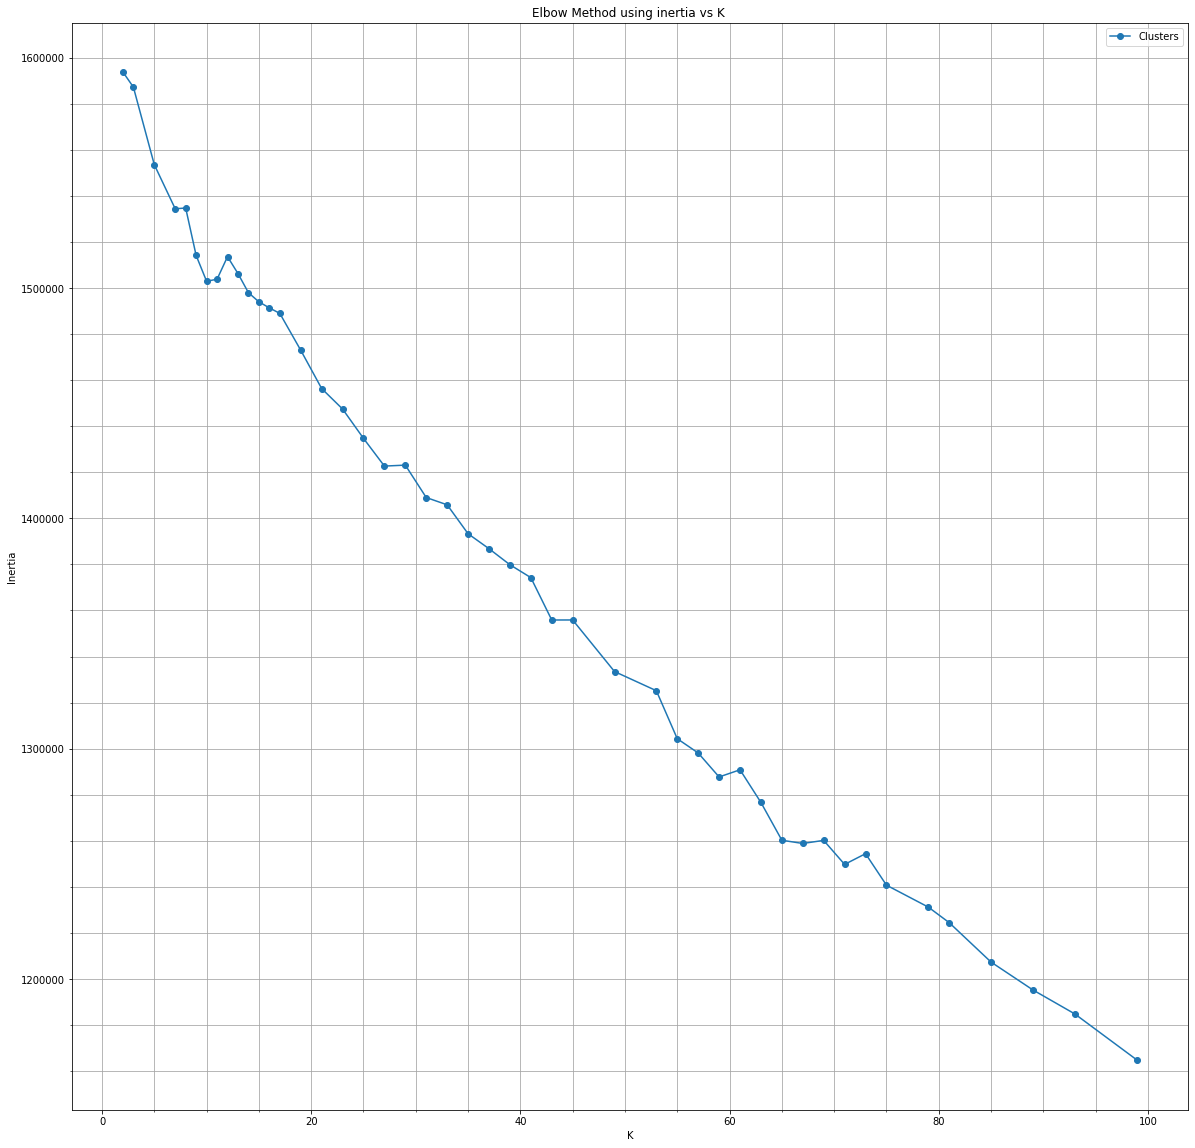

In [60]:
plt.figure(figsize=(20,20))
plt.plot(n_clusters, inertia_kmeans, "-o")
plt.title("Elbow Method using inertia vs K ")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.minorticks_on()
plt.legend(['Clusters', 'Inertia'], loc='upper right')
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

I find it bit confusing what to choose as best K as value of loss keeps decreasing but if we see closely we can see uptill k=10 there is sharp decrease after but too it is decreasing but there slope is not that steeper . Now ofcourse how many clusters we want it depends on how much "granular" cluster we need where each cluster is telling some diiferent "aspect" about data. But for sake of assignment we find **best k=8**

In [0]:
  best_Kmean = KMeans(n_clusters=8, init='k-means++')
  best_model= best_Kmean.fit(svd_train)

In [0]:
cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8=[],[],[],[],[],[],[],[]
for i in range(best_model.labels_.shape[0]):
    if best_model.labels_[i] == 0:
        cluster1.append(X_no_stop_50k_reviews[i])
    elif best_model.labels_[i] == 1:
        cluster2.append(X_no_stop_50k_reviews[i])
    elif best_model.labels_[i] == 2:
        cluster3.append(X_no_stop_50k_reviews[i])
    elif best_model.labels_[i] == 3:
        cluster4.append(X_no_stop_50k_reviews[i])
    elif best_model.labels_[i] == 4:
        cluster5.append(X_no_stop_50k_reviews[i])
    elif best_model.labels_[i] == 5:
        cluster6.append(X_no_stop_50k_reviews[i])
    elif best_model.labels_[i] == 6:
        cluster7.append(X_no_stop_50k_reviews[i]) 
    #elif best_model.labels_[i] == 7:
        #cluster8.append(X_no_stop_50k_reviews[i])
    #elif best_model.labels_[i] == 8:
        #cluster9.append(X_no_stop_50k_reviews[i])  
    else:
        cluster8.append(X_no_stop_50k_reviews[i])

In [73]:
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))
#print("\nNo. of reviews in Cluster-9 : ",len(cluster9))
#print("\nNo. of reviews in Cluster-10 : ",len(cluster10))

No. of reviews in Cluster-1 :  1992

No. of reviews in Cluster-2 :  1

No. of reviews in Cluster-3 :  1

No. of reviews in Cluster-4 :  1

No. of reviews in Cluster-5 :  2

No. of reviews in Cluster-6 :  1

No. of reviews in Cluster-7 :  1

No. of reviews in Cluster-8 :  1


### [5.5] Wordclouds of clusters obtained in the above section

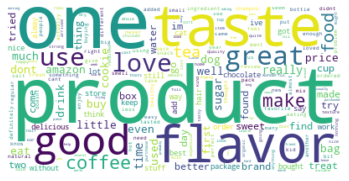

In [74]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

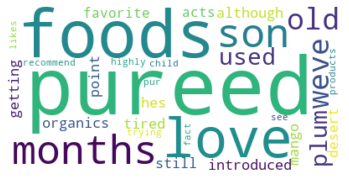

In [75]:

#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

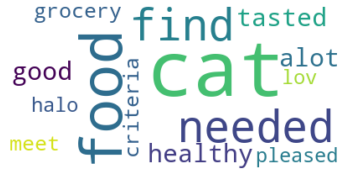

In [77]:

#for cluster 3
data=''
for i in cluster3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

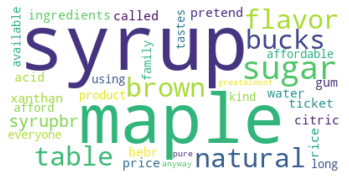

In [78]:

#for cluster 4
data=''
for i in cluster4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

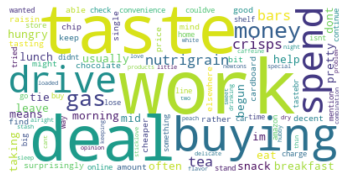

In [79]:

#for cluster 5
data=''
for i in cluster5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

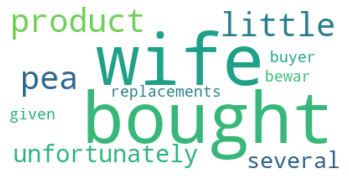

In [80]:

#for cluster 6
data=''
for i in cluster6:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

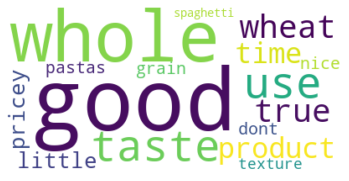

In [81]:

#for cluster 7
data=''
for i in cluster7:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

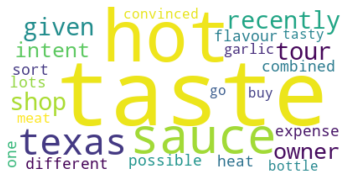

In [82]:

#for cluster 8
data=''
for i in cluster8:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.6] Function that returns most similar words for a given word.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
def similar_words(word,n):
    top_words=[]
    cosine_sim=cosine_similarity(occ_matrix)
    val_word=cosine_sim[lst_2000.index(word)]
    idx=np.argsort(val_word)
    for i in range(n):
        top_words.append(lst_2000[idx[i]])
    return top_words

In [94]:
print('So the Top 10 words similar to word sucrose are ')
print(similar_words('sucrose',10))
print ("#############################")
print('So the Top 10 words similar to word arsenic are ')
print(similar_words('arsenic',10))
print ("#############################")

So the Top 10 words similar to word sucrose are 
['cocaine', 'naked', 'tea tried', 'cant taste', 'found great', 'meatloaf', 'hair products', 'recovery', 'doesnt mean', 'oil great']
#############################
So the Top 10 words similar to word arsenic are 
['cocaine', 'hiding', 'product always', '5050', 'like ones', 'counta', 'fiber protein', 'naked', 'tea tried', 'cant taste']
#############################


# [6] Conclusions

We have done **k=8** for this assignment as mentioned earlier we could have tried many other number of clusters but it very much depends on our requirements and how smaller chunks of cluster we want with how much granulaity.

In this assignment we took top 2000 features only.

As far as finding of similar word is concerned i have used cosine similarity and we see to some extend i was able to find similar words. Example when i tried similar word for arsenic i got 'cocaine' ,'hiding', 'cant taste' which kind of  makes sense. 